## Overview

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
#!unzip  "/gdrive/MyDrive/CaseStudy_HomeCredit/home-credit-default-risk.zip"  -d "/gdrive/MyDrive/CaseStudy_HomeCredit/"

<pre>
Serious complication for loan providers(Banking) is to find out the Loan applicants who are very likely to repay the loan.If the loan provider predicted the faithful customer, they will gain more profit and  more imporatanly they will avoid losses.
In kaggle, Home Credit Default Risk is currently using various statistical and machine learning methods to make these predictions, they're challenging. Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

Here we have two classes in the target label, we will conclude this problem as a <strong> Binary classification </strong> problem.

<strong>Problem Statement</strong>
We need to Build the model,which will say by giving the customer information whether this applicant will repay a loan or not
 
<strong>Data Description</strong>
They are 7 different source of table for this problem, combining all the tables is 221 features.
two main tables are <strong>application_train.csv</strong> and <strong>application_test.csv</strong>, which contain the current applications of the clients who have applied for loan. All the other tables are referenced with this table using the unique ID, i.e. SK_ID_CURR.
For more information, visit - https://www.kaggle.com/c/home-credit-default-risk/data

</pre>

In [2]:
# Import all required package for this problem
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from plotly.offline import iplot
from matplotlib.pyplot import figure
import warnings
warnings.filterwarnings('ignore') 
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, LabelEncoder,OneHotEncoder
from sklearn.impute import SimpleImputer as Imputer
from tqdm import tqdm

import plotly.offline as py
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
import cufflinks as cf
cf.go_offline()
import pickle
import gc
import lightgbm as lgb
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,roc_curve


### Exploratory Data Analysis

Exploratory Data Analysis refers to the critical process of performing initial investigations on data

#### Load Data from given CSV

In [3]:
# Select the directory 
os.chdir('/gdrive/My Drive/CaseStudy_HomeCredit')

### Missing values

<pre>
Missing values in a Dataset will affect model performances, to avoid that need to handle this problem for that we have various method , important method is <strong>Imputer</strong> for that first we need to check missing values deatils in all tables.

</pre>

In [ ]:
def missing_value(dataframe = 'df', df_name ='TRAIN', visualizse = True, head_count = 5):
    '''
    dataframe - Pass the dataframe to the find missing value of each row.
    df_name  -  Dataframe name
    Visualizse - Boolean, True- Visalizse or False - skip the visualizse part
    head_count - print top five missing column in descending column.
    '''
    total = dataframe.isnull().sum().sort_values(ascending=False)
    percent = (dataframe.isnull().sum()/dataframe.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print(missing_data.head(head_count))
    
    if visualizse:
        # visualizse
        figure(figsize=(50,50), facecolor='w', edgecolor='r')
        '''
        edge color - Border color
        dpi - dots-per-inch
        '''
        if len(missing_data.index) >20 :
            sns.set(font_scale = 3)
            sns.barplot(y= missing_data.index, x= missing_data['Percent'])
        else: 
            sns.set(font_scale = 6)
            sns.barplot(y= missing_data.index, x= missing_data['Percent'])
        plt.tight_layout()
        plt.title(str(df_name))
        plt.show()


# <font color='green'> FEATURE ENGINEERING </font>

![image.png](attachment:image.png)

<pre>
From the Exploratory Data Analysis(EDA) we understand the Insight of all tables, major role of feature engineering is selecting best column , best feature selection gives better model. suppose if we have noisy data, model wont give better result. if feature is having missing value either we remove or feature engineering, feature engineering is best because removing noisy features which leads to lack of data.

</pre>

# Reduce memory usage

<pre>

We handling 7 tables, System required a lot of memory intensive computation or data-set size that was large enough to hang my system. so to avoid memory usage problem we going to change the datatype eg - Object to Category, int64 to int32,16,8 deponds on limit of numeric column

</pre>

In [ ]:
def reduce_mem_usage(data, verbose = True):
    # refer - https://medium.com/@aakashgoel12/avoid-memory-error-techniques-to-reduce-dataframe-memory-usage-fcf53b2318a2
    #refer: https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
    '''
    This function is used to reduce the memory usage by converting the datatypes of a pandas
    DataFrame withing required limits.
    '''
    
    start_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('-'*100)
        print('Memory usage of dataframe: {:.2f} MB'.format(start_mem))
    
    for col in data.columns:
        col_type = data[col].dtype
        
        if col_type != object:
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data[col] = data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)

    end_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage after optimization: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
        print('-'*100)
    
    return data

# Read all the tables 

In [ ]:
# Read all madatory files for this task
def read_mandatory_files():
    df = pd.read_csv('application_train.csv')
    df = reduce_mem_usage(df)
    df_test = pd.read_csv('application_test.csv')
    df_test = reduce_mem_usage(df_test)
    df_bureau = pd.read_csv('bureau.csv')
    df_bureau = reduce_mem_usage(df_bureau)
    df_bureau_bal = pd.read_csv('bureau_balance.csv')
    df_bureau_bal = reduce_mem_usage(df_bureau_bal)
    df_prev_app = pd.read_csv('previous_application.csv')
    df_prev_app = reduce_mem_usage(df_prev_app)
    df_pos = pd.read_csv('POS_CASH_balance.csv')
    df_pos = reduce_mem_usage(df_pos)
    df_credit_bal = pd.read_csv('credit_card_balance.csv')
    df_credit_bal = reduce_mem_usage(df_credit_bal)
    df_inst_pay = pd.read_csv('installments_payments.csv')
    df_inst_pay = reduce_mem_usage(df_inst_pay)
    
    return df, df_test, df_bureau,df_bureau_bal,df_prev_app,df_pos, df_credit_bal,df_inst_pay

# Data Cleaning
<pre>
Erroness value in application train and application test tables, to handling we using below function

</pre>

In [ ]:
# Data Cleaning and preprocessing for train and test
def data_cleaning(df='dataframe'):
    df['DAYS_BIRTH'] = round(df['DAYS_BIRTH'] *-1/ 365)

    # abs - convert all value in to postive
    df['DAYS_EMPLOYED']  = abs(df['DAYS_EMPLOYED'])
    df['DAYS_EMPLOYED'].head(2)

    # Replace the anomalous values(Errorness value) with nan
    df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].replace({365243: np.nan})

    # Convert days in to years
    df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'] /365
    
    # Create an anomalous flag column
    df['Year_Empolyed_ANOM'] = df["DAYS_EMPLOYED"] == 365243

    #Invalid Gender code, we have limited entry so we removing
    df = df[df['CODE_GENDER'] != 'XNA']

    df.loc[df['OBS_30_CNT_SOCIAL_CIRCLE'] > 30, 'OBS_30_CNT_SOCIAL_CIRCLE'] = np.nan
    df.loc[df['OBS_60_CNT_SOCIAL_CIRCLE'] > 30, 'OBS_60_CNT_SOCIAL_CIRCLE'] = np.nan
    
    return df

# Replcaing missing value category with XNS (Unknow)

In [ ]:
# replacing Null with XNS -  Unknow category
def replacing_missing_category(df = 'dataframe'):
    # replacing Null with XNS -  Unknow category
    categorical_columns_train = df.dtypes[df.dtypes == 'object'].index.tolist()
    df[categorical_columns_train] = df[categorical_columns_train].fillna('XNA')
    
    # From EDA REGION_RATING_CLIENT and REGION_RATING_CLIENT_W_CITY have discret value, 
    #so we changing this column data type from Int to Object
    
    df['REGION_RATING_CLIENT'] = df['REGION_RATING_CLIENT'].astype('object')
    df['REGION_RATING_CLIENT_W_CITY'] = df['REGION_RATING_CLIENT_W_CITY'].astype('object')
    
    return df

# OneHotEncoding and Label encoder

In [ ]:
## Converting Category in to Numerical representation using Onehot encoder and label encoder
'''
OneHotEncoder -  handle_unknown='ignore'
    unknown category is encountered during
    transform, the resulting one-hot encoded columns for this feature
    will be all zeros.
'''
def category_to_numeric(df = 'dataframe',df_test = 'dataframe2'):
    print('Shape of application train before Encoding ', df.shape)
    print('Shape of application test before Encoding ', df_test.shape)
    cat_df = df.dtypes[df.dtypes == 'object'].index.tolist()
    enc = OneHotEncoder(handle_unknown='ignore')
    for i in tqdm(cat_df):

        enc_df = pd.DataFrame(enc.fit_transform(df[[i]]).toarray().astype('int'),columns=enc.get_feature_names([i]))
        enc_df_test = pd.DataFrame(enc.transform(df_test[[i]]).toarray().astype('int'),columns=enc.get_feature_names([i]))
        df = df.drop(i,axis=1).join(enc_df)
        df_test = df_test.drop(i,axis=1).join(enc_df_test)

    print('Shape of application train after Encoding ', df.shape)
    print('Shape of application test after Encoding ', df_test.shape)  
    
    return df, df_test

# Replacing missing value - dtype Numeric

In [ ]:
# replacing ,missing value with Median
def replacing_missing_numeric(df = 'dataframe', df_test='dataframe2'):
    # Train missing values
    missing_value(df,df_name='TRAIN',visualizse=False,head_count=5)
    # Test missing values
    missing_value(df_test,df_name='TEST',visualizse=False,head_count=10)
    
    ## Fill in missing values

    #Strategy = Median, variances is high so better to use Median
    imputer = Imputer(strategy = 'median')
    scaler = MinMaxScaler(feature_range = [0,1])
    train = df  
    train_col = train.columns

    imputer.fit(train)
    train = imputer.transform(train)
    test = imputer.transform(df_test)
    scaler.fit(train)
    train = scaler.transform(train)
    test = scaler.transform(test)
    print('Training data shape: ', train.shape)
    print('Testing data shape: ', test.shape)
    new_df_train = pd.DataFrame(train,columns=train_col)
    new_df_train['SK_ID_CURR'] = df['SK_ID_CURR'].values
    #new_df_train['TARGET'] = df['TARGET'].values
    
    new_df_test = pd.DataFrame(test,columns=train_col)
    new_df_test['SK_ID_CURR'] = df_test['SK_ID_CURR'].values
    
    print('Missing value_count after Imputation \n')
    missing_value(new_df_train,df_name='TRAIN',visualizse=False,head_count=5)
    # Test missing values
    missing_value(new_df_test,df_name='TEST',visualizse=False,head_count=5)

    print(' Observation : \n 1.Now there is no missing value in Train and test')
    
    
    return new_df_train, new_df_test

# Create new Custom features - application train and test

<pre>

refer - https://www.wellsfargo.com/financial-education/credit-management/five-c/

<strong> <font color = 'blue'>Capacity</font> </strong> : Lenders need to determine whether you can comfortably afford your payments. Your income and employment history are good indicators of your ability to repay outstanding debt. Income amount, stability, and type of income may all be considered. The ratio of your current and any new debt as compared to your before-tax income, known as debt-to-income ratio (DTI), may be evaluated.

<strong> <font color = 'blue'>Collateral</font> </strong>  (when applying for secured loans): Loans, lines of credit, or credit cards you apply for may be secured or unsecured. With a secured product, such as an auto or home equity loan, you pledge something you own as collateral. The value of your collateral will be evaluated, and any existing debt secured by that collateral will be subtracted from the value. The remaining equity will play a factor in the lending decision.

<strong> <font color = 'blue'>Capital</font> </strong>: While your household income is expected to be the primary source of repayment, capital represents the savings, investments, and other assets that can help repay the loan. This can be helpful if you lose your job or experience other setbacks.

<strong> <font color = 'blue'>Conditions</font> </strong>: Lenders may want to know how you plan to use the money and will consider the loan’s purpose, such as whether the loan will be used to purchase a vehicle or other property. Other factors, such as environmental and economic conditions, may also be considered.
</pre>

In [ ]:
def create_custom_features_main_table(df='dataframe1', df_test='dataframe2'):
    ################ Application_ train.csv ###########
    # Flag to represent when Total income is greater than Credit
    df['INCOME_GT_CREDIT_FLAG'] = df['AMT_INCOME_TOTAL'] > df['AMT_CREDIT']

    # Column to represent Credit Income Percent
    df['DIR'] = df['AMT_CREDIT']/(df['AMT_INCOME_TOTAL']+1)

    # Column to represent Annuity Income percent
    df['AIR'] = df['AMT_ANNUITY']/(df['AMT_INCOME_TOTAL']+1)

    # Column to represent Credit Term
    df['ACR'] = (df['AMT_CREDIT']/(df['AMT_ANNUITY']+1))
    

    # Column to represent Days Employed percent in his life
    df['DAR'] = df['DAYS_EMPLOYED']/df['DAYS_BIRTH']

    ################ Application_ test.csv ###########

    df_test['INCOME_GT_CREDIT_FLAG'] = df_test['AMT_INCOME_TOTAL'] > df_test['AMT_CREDIT']
    df_test['DIR'] = df_test['AMT_CREDIT']/(df_test['AMT_INCOME_TOTAL']+ 1)
    df_test['AIR'] = df_test['AMT_ANNUITY']/(df_test['AMT_INCOME_TOTAL'] +1)
    df_test['ACR'] = df_test['AMT_CREDIT']/(df_test['AMT_CREDIT']+1)
    df_test['DAR'] = df_test['DAYS_EMPLOYED']/df_test['DAYS_BIRTH']
    
    return df, df_test


# Create unique Column

In [ ]:
# when merging two table, chance o having same column name in both table, to avoid we settiing new feature name
# Note , pd.Dummies we have prefix attribute, but for numerical field better to use this function
def create_unique_col(table= 'Bureau',data='df', ID ='SK_ID_CURR' ):
    '''
    table - Dataframe name
    data  = Dataframe
    ID    = Foreign key
    return Column name wit prefix table name
    '''
    
    unique_col_bureau = [] 
    for i in data.columns:
        if i != ID:
            col_name = table+str('_')+str(i)
            unique_col_bureau.append(col_name)
        else:
            unique_col_bureau.append(i)
    #print('New Column names  - \n'+str(unique_col_bureau))   
    return unique_col_bureau  

# Create Custom feature - Bureau.csv

In [ ]:
def create_custom_bureau_feature(df_bureau='bureau_table'):
    # Create a new column , using existing information from Bureau
    # Number of past loans per customer
    past_loan = df_bureau.groupby(by = ['SK_ID_CURR'])['SK_ID_BUREAU'].count().reset_index().rename(columns = {'SK_ID_BUREAU': 'LOAN_COUNT_BUREAU'})
    print('Past loan details',past_loan.shape )


    # Number of type of credit loan type per customer
    credit_type = df_bureau[['SK_ID_CURR', 'CREDIT_TYPE']].groupby('SK_ID_CURR')['CREDIT_TYPE'].nunique().reset_index().rename(columns={'CREDIT_TYPE': 'LOAN_TYPES_BUREAU'})
    print('credit_type details',credit_type.shape)


    # total_loan amount still date
    sum_total_count = df_bureau[['SK_ID_CURR', 'AMT_CREDIT_SUM']].groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM': 'TOTAL_LOAN_AMT_SUM'})
    print('sum_total_count details',sum_total_count.shape )


    # total_loan amount debt still date
    sum_total_count_debt = df_bureau[['SK_ID_CURR', 'AMT_CREDIT_SUM_DEBT']].groupby('SK_ID_CURR')['AMT_CREDIT_SUM_DEBT'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM_DEBT': 'TOTAL_LOAN_AMT_SUM_DEBT'})
    print('sum_total_count_debt details',sum_total_count_debt.shape)


    #merge sum_total_count and sum_total_count_debt
    debt_credit_df  =  sum_total_count.merge(sum_total_count_debt,on='SK_ID_CURR')
    debt_credit_df['debt_credit_ratio'] = debt_credit_df['TOTAL_LOAN_AMT_SUM_DEBT'] / (debt_credit_df['TOTAL_LOAN_AMT_SUM'] +1)
    print('Merge of sum_total_count and sum_total_count_debt',debt_credit_df.shape)


    # Sum of AMT_CREDIT_SUM_OVERDUE
    Total_customer_overdue  = df_bureau[['SK_ID_CURR', 'AMT_CREDIT_SUM_OVERDUE']].groupby('SK_ID_CURR')['AMT_CREDIT_SUM_OVERDUE'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM_OVERDUE': 'SUM_AMT_CREDIT_SUM_OVERDUE'})
    print('Sum of over due amount',Total_customer_overdue.shape)
    # sum AMT_CREDIT_SUM_DEBT
    Total_customer_debt =  df_bureau[['SK_ID_CURR','AMT_CREDIT_SUM_DEBT']].groupby(by=['SK_ID_CURR'])['AMT_CREDIT_SUM_DEBT'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM_DEBT':'TOTAL_CUSTOMER_DEBT'})
    print('Sum of total debt amount ',Total_customer_debt.shape)


    sum_overdue_credit_sum  = Total_customer_overdue.merge(Total_customer_debt,on='SK_ID_CURR')
    sum_overdue_credit_sum['overdue_debt_ratio'] = sum_overdue_credit_sum['SUM_AMT_CREDIT_SUM_OVERDUE'] / (sum_overdue_credit_sum['TOTAL_CUSTOMER_DEBT']+1)
    sum_overdue_credit_sum['overdue_debt_ratio'] = sum_overdue_credit_sum['overdue_debt_ratio'].fillna(0)
    sum_overdue_credit_sum['overdue_debt_ratio'] = sum_overdue_credit_sum.replace([np.inf,-np.inf],0)
    sum_overdue_credit_sum['overdue_debt_ratio'] = pd.to_numeric(sum_overdue_credit_sum['overdue_debt_ratio'],downcast='float')
    print('Ratio of Overdue and credit debt amount',sum_overdue_credit_sum.shape)
    
    df_bureau = df_bureau.merge(past_loan,on='SK_ID_CURR',how='left')
    df_bureau =df_bureau.merge(credit_type,on='SK_ID_CURR',how='left')
    df_bureau =df_bureau.merge(debt_credit_df,on='SK_ID_CURR',how='left')
    df_bureau =df_bureau.merge(sum_overdue_credit_sum,on='SK_ID_CURR',how='left')
    
    return df_bureau



# Join application train and bureau.csv

In [ ]:
# Joining application_train and BUREAU.csv
def join_application_bureau(df ='table1', df_bureau = 'table2'):
    # Categorical feature - merging
    # Converting all categorical in to onehot encoding
    categorical_bureau = pd.get_dummies(df_bureau.select_dtypes('object'), prefix='Bureau')
    categorical_bureau['SK_ID_CURR'] = df_bureau['SK_ID_CURR']

    grp_bureau = categorical_bureau.groupby(by = ['SK_ID_CURR']).mean().reset_index()
    print('Column_names_Categorical', grp_bureau.columns)
    
    # Merge train and bureau_categorical
    df_main = df.merge(grp_bureau, on='SK_ID_CURR',how='left')
    df_main.update(df_main[grp_bureau.columns].fillna(0))
    
    # Combining Numerical features

    Numerical_bureau_col = df_bureau.select_dtypes(include=[np.number]).columns
    Numerical_bureau = df_bureau[Numerical_bureau_col]


    grp_bureau_num = Numerical_bureau.drop(['SK_ID_BUREAU'], axis = 1).groupby(by=['SK_ID_CURR']).mean().reset_index()
    print('Column_names_Numeric', grp_bureau_num.columns)

    #There may be some column name for both application and bureau.csv, inorder to avoid we giving unique column name
    grp_bureau_num.columns = create_unique_col(table='Bureau',data=grp_bureau_num,ID='SK_ID_CURR')

    # Merge train and bureau_categorical
    df_main = df_main.merge(grp_bureau_num, on='SK_ID_CURR',how='left')
    df_main.update(df_main[grp_bureau_num.columns].fillna(0))
    
    return df_main




# Join application, bureau and bureau_balance

In [ ]:
# Joining Bureau_Balance data to merge of Application and Bureau(df_main)

def data_cleaning_bureau_bal(df_bureau_bal= 'dataframe'):
    # C - Close , so we giving weight to 0, remaining incremental, thing is X - Unknow so benefit of doubt we giving middle value(4) 
    status_label_encoding = { 'C': 0, '0': 1, '1': 2, '2': 3, 'X': 4, '3': 5, '4': 6, '5': 7}
    df_bureau_bal['STATUS'] = df_bureau_bal['STATUS'].map(status_label_encoding)

    # Monthly Balance is in Negative , easy interpreatation we changing to postive
    df_bureau_bal['MONTHS_BALANCE'] = abs(df_bureau_bal['MONTHS_BALANCE'])

    # Creating new features 'Weightage_balance' = divide Status by Months_balance 
    df_bureau_bal['WEIGHT_status'] = df_bureau_bal['STATUS'] / (df_bureau_bal['MONTHS_BALANCE'] +1)
    
    return df_bureau_bal

def merge_application_BureauBal(df_main='dataframe1', df_bureau='dataframe2', df_bureau_bal='dataframe3'):
    df_bureau_bal = data_cleaning_bureau_bal(df_bureau_bal= df_bureau_bal)
    Bureau_merge_Bureau_bal =  df_bureau.merge(df_bureau_bal, on='SK_ID_BUREAU')
    Bureau_merge_Bureau_bal = Bureau_merge_Bureau_bal[['SK_ID_CURR', 'MONTHS_BALANCE','STATUS','WEIGHT_status']].groupby('SK_ID_CURR')['MONTHS_BALANCE','STATUS','WEIGHT_status'].sum().reset_index()
    Bureau_merge_Bureau_bal.columns = create_unique_col(table='Bureau_bal',data=Bureau_merge_Bureau_bal,ID='SK_ID_CURR')
    df_main = df_main.merge(Bureau_merge_Bureau_bal, on='SK_ID_CURR',how='left')
    df_main.update(df_main[['Bureau_bal_MONTHS_BALANCE','Bureau_bal_STATUS','Bureau_bal_WEIGHT_status']].fillna(0))
    print('Shape of main table after merge Application, Bureau and Bureau_balance', df_main.shape)
    
    return df_main

# Join application, bureau ,bureau_balance and previous application

In [ ]:
def create_custom_prevapp_feature(previous_application='bureau_table'):
    # Create a new column , using existing information from Previous applications
    #https://www.kaggle.com/c/home-credit-default-risk/discussion/64598
    previous_application['AMT_INTEREST'] = previous_application['CNT_PAYMENT'] * previous_application[
                                            'AMT_ANNUITY'] - previous_application['AMT_CREDIT'] 
    previous_application['INTEREST_SHARE'] = previous_application['AMT_INTEREST'] / (previous_application[
                                                                                            'AMT_CREDIT'] + 0.00001)
    previous_application['INTEREST_RATE'] = 2 * 12 * previous_application['AMT_INTEREST'] / (previous_application[
                                        'AMT_CREDIT'] * (previous_application['CNT_PAYMENT'] + 1))
    

    previous_application['AMT_DECLINED'] = previous_application['AMT_APPLICATION'] - previous_application['AMT_CREDIT']

    previous_application['AMT_CREDIT_GOODS_RATIO'] = previous_application['AMT_CREDIT'] / (previous_application['AMT_GOODS_PRICE'] + 0.00001)
    previous_application['AMT_CREDIT_GOODS_DIFF'] = previous_application['AMT_CREDIT'] - previous_application['AMT_GOODS_PRICE']

    previous_application['ANNUITY'] = previous_application['AMT_CREDIT'] / (previous_application['CNT_PAYMENT'] + 0.00001)
    previous_application['ANNUITY_GOODS'] = previous_application['AMT_GOODS_PRICE'] / (previous_application['CNT_PAYMENT'] + 0.00001)
   
    print('After creating custom feature ', previous_application.shape)
    return previous_application



In [ ]:
def merge_application_prev_app(df_main = 'dataframe1',df_prev_app ='dataframe2'):
    Pre_app_count= df_prev_app[['SK_ID_CURR','SK_ID_PREV']].groupby(by=['SK_ID_CURR'])['SK_ID_PREV'].count().reset_index().rename(columns={'SK_ID_PREV':'PREV_APP_COUNT'}).fillna(0)

    # Combining categorical features
    pre_app_categorical = pd.get_dummies(df_prev_app.select_dtypes('object'))
    pre_app_categorical['SK_ID_CURR'] = df_prev_app['SK_ID_CURR']

    grp_PrevApp = pre_app_categorical.groupby('SK_ID_CURR').mean().reset_index()
    grp_PrevApp.columns = create_unique_col(table='PREV_APP',data=grp_PrevApp,ID='SK_ID_CURR')

    # Combine final Previous_Application to df_main
    df_main = df_main.merge(grp_PrevApp,on='SK_ID_CURR',how='left')
    df_main.update(df_main[grp_PrevApp.columns].fillna(0))

    # Combining numerical features
    grp_PrevApp_numeric = df_prev_app.drop('SK_ID_PREV', axis =1).groupby(by=['SK_ID_CURR']).mean().reset_index()
    grp_PrevApp_numeric.columns = create_unique_col(table='PREV_APP',data=grp_PrevApp_numeric,ID='SK_ID_CURR')
    df_main = df_main.merge(grp_PrevApp_numeric, on =['SK_ID_CURR'], how = 'left')
    df_main.update(df_main[grp_PrevApp_numeric.columns].fillna(0))

    print('Shape after merge Application, Bureau, Bureau_Balance and Previous_Application ', df_main.shape)
    return df_main
    
    

## Join application, bureau ,bureau_balance , previous application and point of sale

In [ ]:
def create_custom_pos_feature(pos_cash='dataframe1'):

  #creating new features based on Domain Knowledge
  pos_cash['SK_DPD_RATIO'] = pos_cash['SK_DPD'] / (pos_cash['SK_DPD_DEF'] + 0.00001)
  pos_cash['TOTAL_TERM'] = pos_cash['CNT_INSTALMENT'] + pos_cash['CNT_INSTALMENT_FUTURE']

  print('Shape of POS after feature engineering', pos_cash.shape)

  return pos_cash


In [ ]:
def merge_application_pos(df_main = 'dataframe1',df_pos ='dataframe2'):
    Pre_app_count= df_prev_app[['SK_ID_CURR','SK_ID_PREV']].groupby(by=['SK_ID_CURR'])['SK_ID_PREV'].count().reset_index().rename(columns={'SK_ID_PREV':'PREV_APP_COUNT'}).fillna(0)

    POS_count= df_pos[['SK_ID_CURR','SK_ID_PREV']].groupby(by=['SK_ID_CURR'])['SK_ID_PREV'].count().reset_index().rename(columns={'SK_ID_PREV':'POS_COUNT'}).fillna(0)

    # Combining categorical features
    POS_categorical = pd.get_dummies(df_pos.select_dtypes('object'))
    POS_categorical['SK_ID_CURR'] = df_pos['SK_ID_CURR']

    grp_POS = POS_categorical.groupby('SK_ID_CURR').mean().reset_index()
    grp_POS.columns = create_unique_col(table='POS',data=grp_POS,ID='SK_ID_CURR')

    # Combine final Previous_Application to df_main
    df_main = df_main.merge(grp_POS,on='SK_ID_CURR',how='left')
    df_main.update(df_main[grp_POS.columns].fillna(0))

    # Combining numerical features
    POS_numeric = df_pos.drop('SK_ID_PREV', axis =1).groupby(by=['SK_ID_CURR']).mean().reset_index()
    POS_numeric.columns = create_unique_col(table='POS',data=POS_numeric,ID='SK_ID_CURR')
    df_main = df_main.merge(POS_numeric, on =['SK_ID_CURR'], how = 'left')
    df_main.update(df_main[POS_numeric.columns].fillna(0))

    print('Shape after merge Application, Bureau, Bureau_Balance , Previous_Application and POS ', df_main.shape)
    
    return df_main
    
    

### Join application, bureau ,bureau_balance , previous application,POS and Installment payment

In [ ]:
def create_custom_Inspay_feature(installments_payments='bureau_table'):
    # Create a new column , using existing information from Install payment applications
    installments_payments['AMT_PAYMENT_DIFF'] = installments_payments['AMT_INSTALMENT'] - installments_payments['AMT_PAYMENT']
    installments_payments['AMT_PAYMENT_RATIO'] = installments_payments['AMT_PAYMENT'] / (installments_payments['AMT_INSTALMENT'] + 0.00001)
    installments_payments['DAYS_PAYMENT_RATIO'] = installments_payments['DAYS_INSTALMENT'] / (installments_payments['DAYS_ENTRY_PAYMENT'] + 0.00001)
    installments_payments['DAYS_PAYMENT_DIFF'] = installments_payments['DAYS_INSTALMENT'] - installments_payments['DAYS_ENTRY_PAYMENT']

    print('Shape of InstallPayment after feature engineering', installments_payments.shape)

    return installments_payments
   



In [ ]:
def merge_application_Inspay(df_main = 'dataframe1',df_inst_pay ='dataframe2'):
    INSPAY_numeric = df_inst_pay.drop('SK_ID_PREV', axis =1).groupby(by=['SK_ID_CURR']).mean().reset_index()
    INSPAY_numeric.columns = create_unique_col(table='INSTPAY',data=INSPAY_numeric,ID='SK_ID_CURR')
    df_main = df_main.merge(INSPAY_numeric, on =['SK_ID_CURR'], how = 'left')
    df_main.update(df_main[INSPAY_numeric.columns].fillna(0))

    print('Shape after merge Application, Bureau, Bureau_Balance , Previous_Application, POS and InstantPay ', df_main.shape)
    return df_main

### Join application, bureau ,bureau_balance , previous application,POS , Installment payment and credit balance

In [ ]:
def create_custom_Credit_bal_feature(cc_balance='CCB_table'):

     #Creating new features
        cc_balance['AMT_DRAWING_SUM'] = cc_balance['AMT_DRAWINGS_ATM_CURRENT'] + cc_balance['AMT_DRAWINGS_CURRENT'] + cc_balance[
                                    'AMT_DRAWINGS_OTHER_CURRENT'] + cc_balance['AMT_DRAWINGS_POS_CURRENT']
        cc_balance['BALANCE_LIMIT_RATIO'] = cc_balance['AMT_BALANCE'] / (cc_balance['AMT_CREDIT_LIMIT_ACTUAL'] + 0.00001)
        cc_balance['CNT_DRAWING_SUM'] = cc_balance['CNT_DRAWINGS_ATM_CURRENT'] + cc_balance['CNT_DRAWINGS_CURRENT'] + cc_balance[
                                            'CNT_DRAWINGS_OTHER_CURRENT'] + cc_balance['CNT_DRAWINGS_POS_CURRENT'] + cc_balance['CNT_INSTALMENT_MATURE_CUM']
        cc_balance['MIN_PAYMENT_RATIO'] = cc_balance['AMT_PAYMENT_CURRENT'] / (cc_balance['AMT_INST_MIN_REGULARITY'] + 0.0001)
        cc_balance['PAYMENT_MIN_DIFF'] = cc_balance['AMT_PAYMENT_CURRENT'] - cc_balance['AMT_INST_MIN_REGULARITY']
        cc_balance['MIN_PAYMENT_TOTAL_RATIO'] = cc_balance['AMT_PAYMENT_TOTAL_CURRENT'] / (cc_balance['AMT_INST_MIN_REGULARITY'] +0.00001)
        cc_balance['PAYMENT_MIN_DIFF'] = cc_balance['AMT_PAYMENT_TOTAL_CURRENT'] - cc_balance['AMT_INST_MIN_REGULARITY']
        cc_balance['AMT_INTEREST_RECEIVABLE'] = cc_balance['AMT_TOTAL_RECEIVABLE'] - cc_balance['AMT_RECEIVABLE_PRINCIPAL']
        cc_balance['SK_DPD_RATIO'] = cc_balance['SK_DPD'] / (cc_balance['SK_DPD_DEF'] + 0.00001)

        print('Shape of Credit Card balance after feature engineering', cc_balance.shape)

        return cc_balance

In [ ]:
def merge_application_credit_bal(df_main = 'dataframe1',df_credit_bal ='dataframe2'):
    # Combining categorical features
    CREBAL_categorical = pd.get_dummies(df_credit_bal.select_dtypes('object'))
    CREBAL_categorical['SK_ID_CURR'] = df_credit_bal['SK_ID_CURR']

    grp_CREDBAL = CREBAL_categorical.groupby('SK_ID_CURR').mean().reset_index()
    grp_CREDBAL.columns = create_unique_col(table='CREDITBAL',data=grp_CREDBAL,ID='SK_ID_CURR')

    # Combine final Previous_Application to df_main
    df_main = df_main.merge(grp_CREDBAL,on='SK_ID_CURR',how='left')
    df_main.update(df_main[grp_CREDBAL.columns].fillna(0))

    # Combining numerical features
    CREDBAL_numeric = df_credit_bal.drop('SK_ID_PREV', axis =1).groupby(by=['SK_ID_CURR']).mean().reset_index()
    CREDBAL_numeric.columns = create_unique_col(table='CREDITBAL',data=CREDBAL_numeric,ID='SK_ID_CURR')
    df_main = df_main.merge(CREDBAL_numeric, on =['SK_ID_CURR'], how = 'left')
    df_main.update(df_main[CREDBAL_numeric.columns].fillna(0))

    print('Shape after merge Application, Bureau, Bureau_Balance , Previous_Application, POS, INSTALLMENT PAYMENT and CREDIt BAL ', df_main.shape)
    
    return df_main


In [ ]:
df, df_test, df_bureau,df_bureau_bal,df_prev_app,df_pos, df_credit_bal,df_inst_pay = read_mandatory_files()

df_copy, df_test_new_copy, df_bureau_copy,df_bureau_bal_copy,df_prev_app_copy,df_pos_copy, df_credit_bal_copy,df_inst_pay_copy  = df.copy(), df_test.copy(), df_bureau.copy(),df_bureau_bal.copy(),df_prev_app.copy(),df_pos.copy(), df_credit_bal.copy(),df_inst_pay.copy()

----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 286.23 MB
Memory usage after optimization: 92.38 MB
Decreased by 67.7%
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 45.00 MB
Memory usage after optimization: 14.60 MB
Decreased by 67.6%
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 222.62 MB
Memory usage after optimization: 112.95 MB
Decreased by 49.3%
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

In [ ]:
# Data Cleaning
df =  data_cleaning(df = df)
#df_cv =  data_cleaning(df = df_CV)
df_test =  data_cleaning(df = df_test)


In [ ]:
# Handling missing value-  Category
df =  replacing_missing_category(df = df)
#df_cv =  replacing_missing_category(df = df_CV)
df_test =  replacing_missing_category(df = df_test)

df_test_F = df_test.copy()

In [ ]:
X =  df.drop('TARGET',axis=1)
y =  df['TARGET']


# Split train in to (80% - 20%) as train and test 
X_train, X_test,y_train,y_test  = train_test_split(X, y, test_size =0.2, random_state=123, stratify =y)  


#Split Train 80% into 50% - 50% as train and CV
X_train, X_val,y_train,y_val  = train_test_split(X_train, y_train, test_size =0.5, random_state=123)  

X_train_new = X_train.copy()

print('Shape of X_train ', X_train.shape)
print('Shape validation CV',X_val.shape)
print('Shape of test ',X_test.shape)
print('Shape of y_train ', y_train.shape)
print('Shape of y_test_CV ', y_val.shape)
print('Shape of y_test ', y_test.shape)

df = X_train
df_test = X_val

Shape of X_train  (123002, 122)
Shape validation CV (123003, 122)
Shape of test  (61502, 122)
Shape of y_train  (123002,)
Shape of y_test_CV  (123003,)
Shape of y_test  (61502,)


In [ ]:
# OneHot encoding and Label encoding
df, df_test =  category_to_numeric(df = df, df_test=df_test) 

  0%|          | 0/18 [00:00<?, ?it/s]

Shape of application train before Encoding  (123002, 122)
Shape of application test before Encoding  (123003, 122)


100%|██████████| 18/18 [00:05<00:00,  3.36it/s]

Shape of application train after Encoding  (123002, 255)
Shape of application test after Encoding  (123003, 255)


In [ ]:
# Handling missing value - Numeric
#df, df_test =  replacing_missing_numeric(df = df, df_test=df_test)


In [ ]:
# create custome features for train and test application
df, df_test = create_custom_features_main_table(df=df, df_test=df_test)
print('Shape of application train ', df.shape)
print('Shape of application test ', df_test.shape)

Shape of application train  (123002, 260)
Shape of application test  (123003, 260)


In [ ]:
# Handling missing value-  Category
df ,df_test=  replacing_missing_numeric(df = df,df_test = df_test)


                          Total   Percent
COMMONAREA_MEDI           85943  0.698712
COMMONAREA_AVG            85943  0.698712
COMMONAREA_MODE           85943  0.698712
NONLIVINGAPARTMENTS_MEDI  85405  0.694338
NONLIVINGAPARTMENTS_MODE  85405  0.694338
                          Total   Percent
COMMONAREA_MEDI           85789  0.697455
COMMONAREA_AVG            85789  0.697455
COMMONAREA_MODE           85789  0.697455
NONLIVINGAPARTMENTS_MEDI  85230  0.692910
NONLIVINGAPARTMENTS_MODE  85230  0.692910
NONLIVINGAPARTMENTS_AVG   85230  0.692910
LIVINGAPARTMENTS_AVG      83903  0.682122
LIVINGAPARTMENTS_MEDI     83903  0.682122
LIVINGAPARTMENTS_MODE     83903  0.682122
FLOORSMIN_MEDI            83203  0.676431
Training data shape:  (123002, 260)
Testing data shape:  (123003, 260)
Missing value_count after Imputation 

                  Total  Percent
DAR                   0      0.0
FLAG_DOCUMENT_21      0      0.0
FLAG_DOCUMENT_19      0      0.0
FLAG_DOCUMENT_18      0      0.0
FLAG_DOCUME

In [ ]:
# Bureau table custom features
df_bureau = create_custom_bureau_feature(df_bureau=df_bureau)

Past loan details (305811, 2)
credit_type details (305811, 2)
sum_total_count details (305811, 2)
sum_total_count_debt details (305811, 2)
Merge of sum_total_count and sum_total_count_debt (305811, 4)
Sum of over due amount (305811, 2)
Sum of total debt amount  (305811, 2)
Ratio of Overdue and credit debt amount (305811, 4)


In [ ]:
# Join application and bureau table
df_main = join_application_bureau(df = df, df_bureau=df_bureau)

df_main_test = join_application_bureau(df = df_test, df_bureau=df_bureau)

Column_names_Categorical Index(['SK_ID_CURR', 'Bureau_Active', 'Bureau_Bad debt', 'Bureau_Closed',
       'Bureau_Sold', 'Bureau_currency 1', 'Bureau_currency 2',
       'Bureau_currency 3', 'Bureau_currency 4', 'Bureau_Another type of loan',
       'Bureau_Car loan', 'Bureau_Cash loan (non-earmarked)',
       'Bureau_Consumer credit', 'Bureau_Credit card',
       'Bureau_Interbank credit', 'Bureau_Loan for business development',
       'Bureau_Loan for purchase of shares (margin lending)',
       'Bureau_Loan for the purchase of equipment',
       'Bureau_Loan for working capital replenishment', 'Bureau_Microloan',
       'Bureau_Mobile operator loan', 'Bureau_Mortgage',
       'Bureau_Real estate loan', 'Bureau_Unknown type of loan'],
      dtype='object')
Column_names_Numeric Index(['SK_ID_CURR', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE',
       'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE',
       'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT',
     

In [ ]:
# Join application, bureau and Bureau_balance
df_main = merge_application_BureauBal(df_main=df_main, df_bureau=df_bureau, df_bureau_bal=df_bureau_bal)

df_main_test = merge_application_BureauBal(df_main=df_main_test, df_bureau=df_bureau, df_bureau_bal=df_bureau_bal)


Shape of main table after merge Application, Bureau and Bureau_balance (123002, 306)
Shape of main table after merge Application, Bureau and Bureau_balance (123003, 306)


In [ ]:
#Creating custom features for previous applications
df_prev_app = create_custom_prevapp_feature(previous_application=df_prev_app)

After creating custom feature  (1670214, 45)


In [ ]:
# Join application, bureau , Bureau_balance and previous application
df_main = merge_application_prev_app(df_main=df_main, df_prev_app=df_prev_app)  

df_main_test = merge_application_prev_app(df_main=df_main_test, df_prev_app=df_prev_app)  


Shape after merge Application, Bureau, Bureau_Balance and Previous_Application  (123002, 476)
Shape after merge Application, Bureau, Bureau_Balance and Previous_Application  (123003, 476)


In [ ]:
# create new feature based on existing column in POS table
df_pos = create_custom_pos_feature(pos_cash=df_pos)

Shape of POS after feature engineering (10001358, 10)


In [ ]:
# Join application, bureau , Bureau_balance , previous application and pos
df_main = merge_application_pos(df_main=df_main, df_pos=df_pos)  

df_main_test = merge_application_pos(df_main=df_main_test, df_pos=df_pos)  


Shape after merge Application, Bureau, Bureau_Balance , Previous_Application and POS  (123002, 492)
Shape after merge Application, Bureau, Bureau_Balance , Previous_Application and POS  (123003, 492)


In [ ]:
#Creating custom features - Install payment features
df_inst_pay  = create_custom_Inspay_feature(installments_payments=df_inst_pay)

Shape of InstallPayment after feature engineering (13605401, 12)


In [ ]:
# Join application, bureau , Bureau_balance , previous application , pos and Installment payment
df_main = merge_application_Inspay(df_main=df_main, df_inst_pay=df_inst_pay) 

df_main_test = merge_application_Inspay(df_main=df_main_test, df_inst_pay=df_inst_pay)  

Shape after merge Application, Bureau, Bureau_Balance , Previous_Application, POS and InstantPay  (123002, 502)
Shape after merge Application, Bureau, Bureau_Balance , Previous_Application, POS and InstantPay  (123003, 502)


In [ ]:
# Create new feature Creditcard balance
df_credit_bal = create_custom_Credit_bal_feature(cc_balance=df_credit_bal)

Shape of Credit Card balance after feature engineering (3840312, 31)


In [ ]:
# Join application, bureau , Bureau_balance , previous application , pos , Installment payment and Credit balance

df_main = merge_application_credit_bal(df_main=df_main, df_credit_bal=df_credit_bal)  

df_main_test = merge_application_credit_bal(df_main=df_main_test, df_credit_bal=df_credit_bal)  

Shape after merge Application, Bureau, Bureau_Balance , Previous_Application, POS, INSTALLMENT PAYMENT and CREDIt BAL  (123002, 537)
Shape after merge Application, Bureau, Bureau_Balance , Previous_Application, POS, INSTALLMENT PAYMENT and CREDIt BAL  (123003, 537)


In [ ]:
df_main.shape

(123002, 537)

In [ ]:
df_main.head(3)

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,...,INSTPAY_AMT_PAYMENT,INSTPAY_AMT_PAYMENT_DIFF,INSTPAY_AMT_PAYMENT_RATIO,INSTPAY_DAYS_PAYMENT_RATIO,INSTPAY_DAYS_PAYMENT_DIFF,CREDITBAL_NAME_CONTRACT_STATUS_Active,CREDITBAL_NAME_CONTRACT_STATUS_Approved,CREDITBAL_NAME_CONTRACT_STATUS_Completed,CREDITBAL_NAME_CONTRACT_STATUS_Demand,CREDITBAL_NAME_CONTRACT_STATUS_Refused,CREDITBAL_NAME_CONTRACT_STATUS_Sent proposal,CREDITBAL_NAME_CONTRACT_STATUS_Signed,CREDITBAL_MONTHS_BALANCE,CREDITBAL_AMT_BALANCE,CREDITBAL_AMT_CREDIT_LIMIT_ACTUAL,CREDITBAL_AMT_DRAWINGS_ATM_CURRENT,CREDITBAL_AMT_DRAWINGS_CURRENT,CREDITBAL_AMT_DRAWINGS_OTHER_CURRENT,CREDITBAL_AMT_DRAWINGS_POS_CURRENT,CREDITBAL_AMT_INST_MIN_REGULARITY,CREDITBAL_AMT_PAYMENT_CURRENT,CREDITBAL_AMT_PAYMENT_TOTAL_CURRENT,CREDITBAL_AMT_RECEIVABLE_PRINCIPAL,CREDITBAL_AMT_RECIVABLE,CREDITBAL_AMT_TOTAL_RECEIVABLE,CREDITBAL_CNT_DRAWINGS_ATM_CURRENT,CREDITBAL_CNT_DRAWINGS_CURRENT,CREDITBAL_CNT_DRAWINGS_OTHER_CURRENT,CREDITBAL_CNT_DRAWINGS_POS_CURRENT,CREDITBAL_CNT_INSTALMENT_MATURE_CUM,CREDITBAL_SK_DPD,CREDITBAL_SK_DPD_DEF,CREDITBAL_AMT_DRAWING_SUM,CREDITBAL_BALANCE_LIMIT_RATIO,CREDITBAL_CNT_DRAWING_SUM,CREDITBAL_MIN_PAYMENT_RATIO,CREDITBAL_PAYMENT_MIN_DIFF,CREDITBAL_MIN_PAYMENT_TOTAL_RATIO,CREDITBAL_AMT_INTEREST_RECEIVABLE,CREDITBAL_SK_DPD_RATIO
0,306015,0.0,0.094750,0.033708,0.027417,0.033708,1.000000,0.604167,0.128085,0.940902,0.715244,0.032967,0.0,1.0,0.0,1.0,0.0,0.0,0.066667,0.652174,0.0,0.0,0.0,0.0,0.0,0.0,0.546875,0.860080,0.719181,0.124695,0.156372,0.972168,0.619141,0.000000,0.160034,0.137939,0.291748,0.333252,0.000000,0.101685,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,437259,0.0,0.019312,0.039640,0.043111,0.033708,0.134904,0.291667,0.021552,0.702547,0.469159,0.098901,0.0,1.0,1.0,1.0,1.0,0.0,0.000000,0.434783,0.0,0.0,0.0,0.0,0.0,0.0,0.291534,0.458594,0.597038,0.738281,1.000000,0.983887,0.769043,0.297119,0.919922,0.792969,0.333252,0.375000,0.317139,0.582520,...,9032.610352,0.0,1.0,0.957520,27.078125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,258232,0.0,0.014283,0.122826,0.062075,0.104494,0.088369,0.895833,0.091457,0.803559,0.280441,0.098901,0.0,0.0,0.0,1.0,0.0,0.0,0.066667,0.652174,0.0,0.0,0.0,0.0,0.0,0.0,0.875469,0.456310,0.739356,0.087585,0.076477,0.981934,0.755371,0.021194,0.000000,0.137939,0.166748,0.208252,0.048187,0.075623,...,11886.930664,0.0,1.0,0.976074,23.281250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Notes

I have completed Data cleaning , feature engineering totally we have 515 features, but still we can create more features so please suggest some blog which related to this domain or any suggestion to create more features.

kindly review the steps which i followed if any concrens please let me know.

In [ ]:
df_main.to_csv('Stack_Home_credit_final.csv', index=False)

In [ ]:
df_main_test.to_csv('Stack_Home_credit_test_final.csv', index=False)

## Dividing final data into train, valid and test datasets:

In [ ]:
# Unseen Data prepartion 
def unseen_data(df='Main_data', df_test='test_data',df_bureau ='df_bureau',df_bureau_bal='df_bureau_bal',df_prev_app ='df_prev_app',df_pos='df_pos',
                df_credit_bal ='df_credit_bal',df_inst_pay='df_inst_pay'):


  # OneHot encoding and Label encoding
  df, df_test =  category_to_numeric(df = df, df_test=df_test)   

  # create custome features for train and test application
  df, df_test = create_custom_features_main_table(df=df, df_test=df_test)
  print('Shape of application train ', df.shape)
  print('Shape of application test ', df_test.shape)

    # Handling missing value-  Category
  df ,df_test=  replacing_missing_numeric(df = df,df_test = df_test)

  # Bureau table custom features
  df_bureau = create_custom_bureau_feature(df_bureau=df_bureau)

  # Join application and bureau table
  df_main_test = join_application_bureau(df = df_test, df_bureau=df_bureau)

  # Join application, bureau and Bureau_balance
  df_main_test = merge_application_BureauBal(df_main=df_main_test, df_bureau=df_bureau, df_bureau_bal=df_bureau_bal)

  #Creating custom features for previous applications
  df_prev_app = create_custom_prevapp_feature(previous_application=df_prev_app)


  # Join application, bureau , Bureau_balance and previous application
  df_main_test = merge_application_prev_app(df_main=df_main_test, df_prev_app=df_prev_app)  

  # create new feature based on existing column in POS table
  df_pos = create_custom_pos_feature(pos_cash=df_pos)

  # Join application, bureau , Bureau_balance , previous application and pos
  df_main_test = merge_application_pos(df_main=df_main_test, df_pos=df_pos)  

  #Creating custom features - Install payment features
  df_inst_pay  = create_custom_Inspay_feature(installments_payments=df_inst_pay)

  # Join application, bureau , Bureau_balance , previous application , pos and Installment payment
  df_main_test = merge_application_Inspay(df_main=df_main_test, df_inst_pay=df_inst_pay)  

  # Create new feature Creditcard balance
  df_credit_bal = create_custom_Credit_bal_feature(cc_balance=df_credit_bal)

  # Join application, bureau , Bureau_balance , previous application , pos , Installment payment and Credit balance
  df_main_test = merge_application_credit_bal(df_main=df_main_test, df_credit_bal=df_credit_bal)  

  print('Shape of unseen test after preprocessing')

  return df_main_test





In [ ]:
X_train = pd.read_csv('Home_credit_final.csv')
X_test = pd.read_csv('Home_credit_test_final.csv')

In [ ]:

unseen_X_test = unseen_data(df=X_train_new, df_test=X_test,df_bureau =df_bureau_copy,df_bureau_bal=df_bureau_bal_copy,df_prev_app =df_prev_app_copy,df_pos=df_pos_copy,
                df_credit_bal =df_credit_bal_copy,df_inst_pay=df_inst_pay_copy)

unseen_X_test.to_csv('Stack_Home_credit_X_test.csv', index=False)

  6%|▌         | 1/18 [00:00<00:03,  5.24it/s]

Shape of application train before Encoding  (123002, 122)
Shape of application test before Encoding  (61502, 122)


100%|██████████| 18/18 [00:04<00:00,  4.21it/s]


Shape of application train after Encoding  (123002, 255)
Shape of application test after Encoding  (61502, 255)
Shape of application train  (123002, 260)
Shape of application test  (61502, 260)
                          Total   Percent
COMMONAREA_MEDI           85943  0.698712
COMMONAREA_AVG            85943  0.698712
COMMONAREA_MODE           85943  0.698712
NONLIVINGAPARTMENTS_MEDI  85405  0.694338
NONLIVINGAPARTMENTS_MODE  85405  0.694338
                                       Total   Percent
NAME_EDUCATION_TYPE_Higher education   49339  0.802234
OCCUPATION_TYPE_IT staff               49339  0.802234
OCCUPATION_TYPE_Sales staff            49339  0.802234
OCCUPATION_TYPE_Realty agents          49339  0.802234
OCCUPATION_TYPE_Private service staff  49339  0.802234
OCCUPATION_TYPE_Medicine staff         49339  0.802234
OCCUPATION_TYPE_Managers               49339  0.802234
OCCUPATION_TYPE_Low-skill Laborers     49339  0.802234
OCCUPATION_TYPE_Laborers               49339  0.802234
OCCU

In [ ]:
#test_kaggle = pd.read_csv('application_test.csv')
unseen_test = unseen_data(df=X_train_new, df_test=df_test_F,df_bureau =df_bureau_copy,df_bureau_bal=df_bureau_bal_copy,df_prev_app =df_prev_app_copy,df_pos=df_pos_copy,
                df_credit_bal =df_credit_bal_copy,df_inst_pay=df_inst_pay_copy)

unseen_test.to_csv('Stack_Home_credit_Actual_test.csv', index=False)

  0%|          | 0/18 [00:00<?, ?it/s]

Shape of application train before Encoding  (123002, 122)
Shape of application test before Encoding  (48744, 122)


100%|██████████| 18/18 [00:04<00:00,  4.27it/s]


Shape of application train after Encoding  (123002, 255)
Shape of application test after Encoding  (48744, 255)
Shape of application train  (123002, 260)
Shape of application test  (48744, 260)
                          Total   Percent
COMMONAREA_MEDI           85943  0.698712
COMMONAREA_AVG            85943  0.698712
COMMONAREA_MODE           85943  0.698712
NONLIVINGAPARTMENTS_MEDI  85405  0.694338
NONLIVINGAPARTMENTS_MODE  85405  0.694338
                          Total   Percent
COMMONAREA_MEDI           33495  0.687161
COMMONAREA_AVG            33495  0.687161
COMMONAREA_MODE           33495  0.687161
NONLIVINGAPARTMENTS_AVG   33347  0.684125
NONLIVINGAPARTMENTS_MEDI  33347  0.684125
NONLIVINGAPARTMENTS_MODE  33347  0.684125
LIVINGAPARTMENTS_AVG      32780  0.672493
LIVINGAPARTMENTS_MODE     32780  0.672493
LIVINGAPARTMENTS_MEDI     32780  0.672493
FLOORSMIN_MODE            32466  0.666051
Training data shape:  (123002, 260)
Testing data shape:  (48744, 260)
Missing value_count af

In [ ]:

# Saving the numpy arrays into text files for future use
np.savetxt('y.txt', y,fmt='%10.0f')
np.savetxt('y_train.txt', y_train,fmt='%10.0f')
np.savetxt('y_val.txt', y_val,fmt='%10.0f')
np.savetxt('y_test.txt', y_test,fmt='%10.0f')

# **<font color = 'orange'> STACK_MODELING </font>**

**What is Stacking?**
The simplest form of stacking can be described as an ensemble learning technique where the predictions of multiple classifiers (referred as level-one classifiers) are used as new features to train a meta-classifier. The meta-classifier can be any classifier of your choice. Figure 1 shows how three different classifiers get trained. Their predictions get stacked and are used as features to train the meta-classifier which makes the final prediction.

In [4]:
###############################################################################
#                          1. Importing Libraries                             #
###############################################################################
# For reading, visualizing, and preprocessing data
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,roc_curve,precision_score,recall_score,f1_score
import gc
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import ExtraTreesClassifier
from pprint import pprint
from scipy.stats import uniform

# Classifiers
from sklearn.svm import NuSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier # --> This libraries we going to explore
from xgboost import XGBClassifier
# Used to ignore warnings generated from StackingCVClassifier
import warnings
warnings.simplefilter('ignore')

In [5]:
# Read all required Data
X_train = pd.read_csv('Stack_Home_credit_final.csv')
X_val = pd.read_csv('Stack_Home_credit_test_final.csv')
X_test = pd.read_csv('Stack_Home_credit_X_test.csv')

Actual_test = pd.read_csv('Stack_Home_credit_Actual_test.csv')

y_train = pd.read_csv('y_train.txt',names=['TARGETS'])
y_val = pd.read_csv('y_val.txt',names=['TARGETS'])
y_test = pd.read_csv('y_test.txt',names=['TARGETS'])




In [6]:
print('Shape of X_train ', X_train.shape)
print('Shape validation CV',X_val.shape)
print('Shape of test ',X_test.shape)
print('Shape of y_train ', y_train.shape)
print('Shape of y_test_CV ', y_val.shape)
print('Shape of y_test ', y_test.shape)

Shape of X_train  (123002, 537)
Shape validation CV (123003, 537)
Shape of test  (61502, 537)
Shape of y_train  (123002, 1)
Shape of y_test_CV  (123003, 1)
Shape of y_test  (61502, 1)


In [7]:
#Reading the best picture using pickle file
import pickle

# Selecting best features for our probelm statement
infile = open('select_features.txt','rb')
selected_features = pickle.load(infile)  

In [ ]:
def plot_confusion_matrix(test_y, predicted_y):
    # Confusion matrix
    C = confusion_matrix(test_y, predicted_y)
    
    # Recall matrix
    A = (((C.T)/(C.sum(axis=1))).T)
    
    # Precision matrix
    B = (C/C.sum(axis=0))
    
    plt.figure(figsize=(20,4))
    
    labels = ['Re-paid(0)','Not Re-paid(1)']
    cmap=sns.light_palette("seagreen")
    plt.subplot(1,3,1)
    sns.heatmap(C, annot=True, cmap=cmap,fmt="g", xticklabels = labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Orignal Class')
    plt.title('Confusion matrix')
    
    plt.subplot(1,3,2)
    sns.heatmap(A, annot=True, cmap=cmap, xticklabels = labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Orignal Class')
    plt.title('Recall matrix')
    
    plt.subplot(1,3,3)
    sns.heatmap(B, annot=True, cmap=cmap, xticklabels = labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Orignal Class')
    plt.title('Precision matrix')
    
    plt.show()


def cv_plot(alpha, cv_auc):
    
    fig, ax = plt.subplots()
    ax.plot(np.log10(alpha), cv_auc,c='g')
    for i, txt in enumerate(np.round(cv_auc,3)):
        ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_auc[i]))
    plt.grid()
    plt.xticks(np.log10(alpha))
    plt.title("Cross Validation Error for each alpha")
    plt.xlabel("Alpha i's")
    plt.ylabel("Error measure")
    plt.show()

In [8]:
# For the latest nightly build:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=755881aacc519714bb86664b363fa9b2d531c4803e476a648ccc7671a8706d80
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [9]:
from bayes_opt import BayesianOptimization


In [ ]:

def xgb_evaluation(max_depth, min_child_weight, gamma, subsample, colsample_bytree, colsample_bylevel,
                   colsample_bynode, reg_alpha, reg_lambda):
    '''
    Objective function for Bayesian Optimization of XGBoost's Hyperparamters. Takes the hyperparameters as input, and
    returns the Cross-Validation AUC as output.
    
    Inputs: Hyperparamters to be tuned.
        max_depth, min_child_weight, gamma, subsample, colsample_bytree, colsample_bylevel,
        colsample_bynode, reg_alpha, reg_lambda
        
    Returns:
        CV ROC-AUC Score
    '''
    params = {
        'learning_rate' : 0.01,
        'n_estimators' : 10000,
        'tree_method' : 'gpu_hist',
        'gpu_id' : 0,
        'max_depth' : int(round(max_depth)),
        'min_child_weight' : int(round(min_child_weight)),
        'subsample': subsample,
        'gamma' : gamma,
        'colsample_bytree' : colsample_bytree,
        'colsample_bylevel' : colsample_bylevel,
        'colsample_bynode' : colsample_bynode,
        'reg_alpha' : reg_alpha,
        'reg_lambda' : reg_lambda,
        'random_state' : 51412
    }    
    

    infile = open('select_features.txt','rb')
    selected_features = pickle.load(infile)  

    x_tr  = X_train[selected_features].drop('SK_ID_CURR',axis=1)
    y_tr = y_train
    x_cv = X_val[selected_features].drop('SK_ID_CURR',axis=1)
    y_cv = y_val
    
    xgbc = XGBClassifier(**params)
    xgbc.fit(x_tr, y_tr, eval_set= [(x_cv,y_cv)],
                    eval_metric='auc', verbose = False, early_stopping_rounds=200)
    
    cv_preds = xgbc.predict_proba(x_cv, ntree_limit = xgbc.get_booster().best_ntree_limit)[:,1]
    gc.collect()   
        
    return roc_auc_score(y_cv, cv_preds)



#defining the optimizer and the hyperparameters along with ranges of values.
bopt_xgb =  BayesianOptimization(xgb_evaluation, {'max_depth' : (5,15),
                                                  'min_child_weight' : (5,80),
                                                  'gamma' : (0.2,1),
                                                  'subsample' : (0.5,1),
                                                  'colsample_bytree' : (0.5,1),
                                                  'colsample_bylevel' : (0.3,1),
                                                  'colsample_bynode' : (0.3,1),
                                                  'reg_alpha' : (0.001, 0.3),
                                                  'reg_lambda' : (0.001, 0.3)}, 
                                 random_state = 55)

bopt_xgb.maximize(n_iter = 6, init_points = 4)    

|   iter    |  target   | colsam... | colsam... | colsam... |   gamma   | max_depth | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.775    |  0.3652   |  0.9802   |  0.7419   |  0.394    |  10.31    |  26.42    |  0.2589   |  0.01329  |  0.5542   |
|  2        |  0.7759   |  0.837    |  0.336    |  0.8879   |  0.2073   |  11.18    |  66.4     |  0.2697   |  0.2957   |  0.7484   |
|  3        |  0.7756   |  0.5466   |  0.907    |  0.6984   |  0.7149   |  5.205    |  65.61    |  0.1295   |  0.168    |  0.8896   |
|  4        |  0.7749   |  0.5818   |  0.9356   |  0.825    |  0.7818   |  12.8     |  31.3     |  0.006878 |  0.1082   |  0.6516   |
|  5        |  0.7765   |  0.5329   |  0.9076   |  0.5274   |  0.8258   |  14.93    |  79.97    |  0.2289   |  0.1489   |  0.9107   |
|  6        |  0.775    |  0.795    |  0.911    |  0.9591   | 

In [ ]:
#extracting the best parameters
target_values = []
for result in bopt_xgb.res:
    target_values.append(result['target'])
    if result['target'] == max(target_values):
        best_params = result['params']
    
print("Best Hyperparameters for XGBoost are:\n")
print(best_params)

Best Hyperparameters for XGBoost are:

{'colsample_bylevel': 0.9916557759356903, 'colsample_bynode': 0.3169533655589153, 'colsample_bytree': 0.5846482004341143, 'gamma': 0.8345255608407902, 'max_depth': 14.804799658733838, 'min_child_weight': 79.94486602836723, 'reg_alpha': 0.03118709395460912, 'reg_lambda': 0.29822101140883434, 'subsample': 0.546435163449364}


Test Dataset Results:
	ROC-AUC Score = 0.7682024066315315
	Precision Score = 0.5663082437275986
	Recall Score = 0.015964433666767707
	F1_Score  = 0.031053459119496855


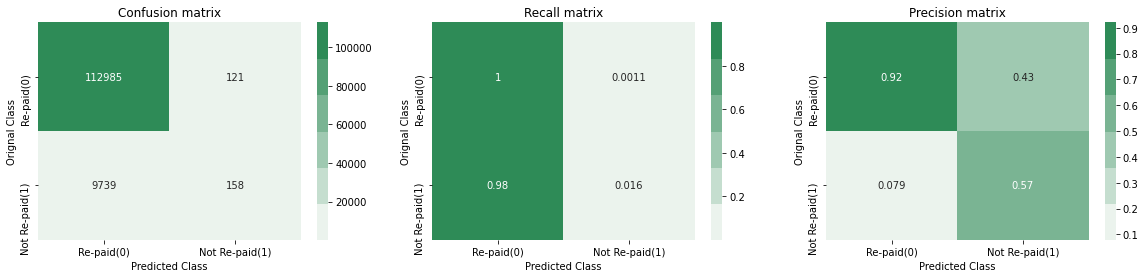

In [ ]:
param_xg = {'colsample_bylevel': 0.9916557759356903, 'colsample_bynode': 0.3169533655589153, 'colsample_bytree': 0.5846482004341143, 
            'gamma': 0.8345255608407902, 'max_depth': 15, 'min_child_weight': 79.94486602836723, 
            'reg_alpha': 0.03118709395460912, 'reg_lambda': 0.29822101140883434, 'subsample': 0.546435163449364}
xgbc = XGBClassifier(**param_xg,random_state=123)

xgbc.fit(X_train[selected_features], y_train, eval_set= [(X_val[selected_features],y_val)],
                eval_metric='auc', verbose = False, early_stopping_rounds=200)

#cv_preds_xgboost = np.zeros(x_tr.shape[0])
Xg_boost = xgbc.predict_proba(X_val[selected_features], ntree_limit = xgbc.get_booster().best_ntree_limit)[:,1]
predict_test = xgbc.predict(X_val[selected_features])


print('=' * 110)
print("Test Dataset Results:")
print(f"\tROC-AUC Score = {roc_auc_score(y_val, Xg_boost)}")
print(f"\tPrecision Score = {precision_score(y_val, predict_test)}")
print(f"\tRecall Score = {recall_score(y_val, predict_test)}")
print(f"\tF1_Score  = {f1_score(y_val, predict_test)}")
plot_confusion_matrix(y_val, predict_test)

# <font color= 'blue'> RANDOM_FOREST STACK </font>

In [24]:


clf = RandomForestClassifier(random_state = 123)
hyperparams = {
      'n_estimators' : [200,500,1000],   
      'max_depth' : list(range(10,30)),
      'min_samples_split' : list(range(5,50)),
      'min_samples_leaf' : list(range(2,50)),
      'max_samples' : uniform(0,1)
      
      }

print(hyperparams)

def evaluate(model, X_test, y_test):
    predicted_proba_test = model.predict_proba(X_test[selected_features])[:,1]
    predict_test = model.predict(X_test[selected_features])


    print('=' * 110)
    print("Test Dataset Results:")
    print(f"\tROC-AUC Score = {roc_auc_score(y_test, predicted_proba_test)}")
    print(f"\tPrecision Score = {precision_score(y_test, predict_test)}")
    print(f"\tRecall Score = {recall_score(y_test, predict_test)}")
    print(f"\tF1_Score  = {f1_score(y_test, predict_test)}")
    plot_confusion_matrix(y_test, predict_test)



rscv = RandomizedSearchCV(estimator = clf, param_distributions = hyperparams, n_iter = 10, scoring = 'roc_auc', 
                           cv = None, return_train_score = True, verbose = 2,
                          n_jobs = -1, random_state = 123)

rscv.fit(X_train[selected_features], y_train)
# to see Best Parameter selection
print('**'*60)
print(rscv.best_params_ )
print('**'*60)

{'n_estimators': [200, 500, 1000], 'max_depth': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 'min_samples_split': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], 'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], 'max_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2bdce6a630>}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 106.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 133.0min finished
***********************************************************************************************************

Test Dataset Results:
	ROC-AUC Score = 0.7563971279293874
	Precision Score = 0.472
	Recall Score = 0.04172981711629787
	F1_Score  = 0.0766802822131452


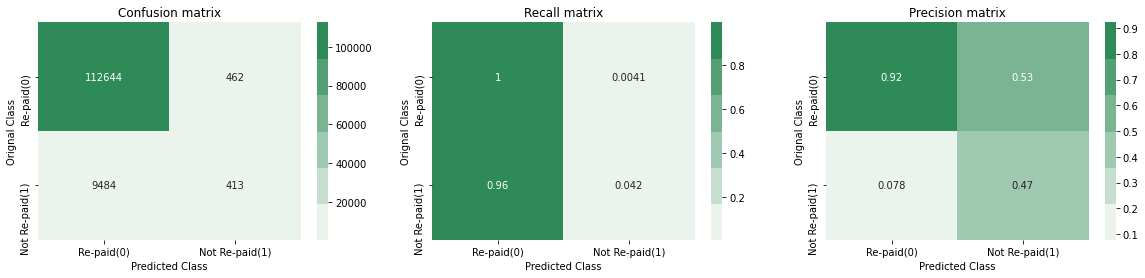

In [ ]:
param_RF = {'max_depth': 17, 'max_samples': 0.7123301813887625, 'min_samples_leaf': 49, 'min_samples_split': 12, 'n_estimators': 500}
clf = RandomForestClassifier(**param_RF,random_state = 123)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(X_train[selected_features], y_train)
base_RocAUC = evaluate(sig_clf, X_val, y_val)

# <font color= blue >STACK LIGHT GBM </font>

In [ ]:
weight = np.ones((len(X_train),), dtype=int)
for i in range(len(X_train)):
    if int(y_train.iloc[i])== 0:
        weight[i]=1
    else:
        weight[i]=11

train_data=lgb.Dataset(X_train[selected_features], label = y_train, weight= weight )
valid_data=lgb.Dataset(X_val[selected_features], label = y_val)
cv_auc_score = []
max_depth = [3, 5, 7, 10]
for i in max_depth:
   
  params = {'boosting_type': 'gbdt',
      'max_depth' : i,
      'objective': 'binary',
      'nthread': 5,
      'num_leaves': 32,
      'learning_rate': 0.05,
      'max_bin': 512,
      'subsample_for_bin': 200,
      'subsample': 0.7,
      'subsample_freq': 1,
      'colsample_bytree': 0.8,
      'reg_alpha': 20,
      'reg_lambda': 20,
      'min_split_gain': 0.5,
      'min_child_weight': 1,
      'min_child_samples': 10,
      'scale_pos_weight': 1,
      'num_class' : 1,
      'metric' : 'auc'
      }
  lgbm = lgb.train(params,
              train_data,
              1500,
              valid_sets=valid_data,
              early_stopping_rounds= 100,
              verbose_eval= 10
              )
  y_pred_prob = lgbm.predict(X_val[selected_features])
  cv_auc_score.append(roc_auc_score(y_val,y_pred_prob))
  print('For  max_depth {0} and some other parameters, cross validation AUC score {1}'.format(i,roc_auc_score(y_val,y_pred_prob)))
print('**'*60)  
print('The optimal  max_depth: ', max_depth[np.argmax(cv_auc_score)])
print('**'*60)  


Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.718062
[20]	valid_0's auc: 0.722674
[30]	valid_0's auc: 0.727686
[40]	valid_0's auc: 0.732828
[50]	valid_0's auc: 0.737873
[60]	valid_0's auc: 0.741624
[70]	valid_0's auc: 0.744317
[80]	valid_0's auc: 0.74675
[90]	valid_0's auc: 0.749168
[100]	valid_0's auc: 0.75106
[110]	valid_0's auc: 0.753163
[120]	valid_0's auc: 0.754345
[130]	valid_0's auc: 0.755751
[140]	valid_0's auc: 0.757038
[150]	valid_0's auc: 0.758224
[160]	valid_0's auc: 0.759076
[170]	valid_0's auc: 0.759895
[180]	valid_0's auc: 0.760584
[190]	valid_0's auc: 0.761394
[200]	valid_0's auc: 0.762111
[210]	valid_0's auc: 0.762787
[220]	valid_0's auc: 0.763417
[230]	valid_0's auc: 0.76391
[240]	valid_0's auc: 0.764402
[250]	valid_0's auc: 0.76499
[260]	valid_0's auc: 0.765485
[270]	valid_0's auc: 0.765959
[280]	valid_0's auc: 0.766319
[290]	valid_0's auc: 0.766365
[300]	valid_0's auc: 0.766798
[310]	valid_0's auc: 0.767075
[320]	valid_0's auc:

# <font color=blue > EXTRACLASSIFIER STACK </font>

In [10]:

params = {
    'n_jobs' : -1,
    'bootstrap' : True,
    'random_state' : 210,
    'class_weight' : 'balanced_subsample',
    'verbose' : 0
}
clf = ExtraTreesClassifier(**params)
hyperparams = {
    'n_estimators' : list(range(500, 1000)),
    'max_depth' : list(range(10,20)),
    'min_samples_split' : list(range(5,20)),
    'min_samples_leaf' : list(range(2,20)),
    'max_samples' : uniform(0,1)   
}

rscv = RandomizedSearchCV(estimator = clf, param_distributions = hyperparams, n_iter = 10, scoring = 'roc_auc', 
                           cv = None, return_train_score = True, verbose = 2,
                          n_jobs = -1, random_state = 123)

rscv.fit(X_train[selected_features], y_train)
# to see Best Parameter selection
print('**'*60)
print(rscv.best_params_ )
print('**'*60)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 59.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 81.9min finished


************************************************************************************************************************
{'max_depth': 14, 'max_samples': 0.5018366758843366, 'min_samples_leaf': 18, 'min_samples_split': 11, 'n_estimators': 770}
************************************************************************************************************************


# <font color=blue > SVM STACK </font>

In [11]:
params = {
      'loss' : 'hinge',
      'class_weight' : 'balanced',
      'random_state' : 123,
      'n_jobs' : -1
  }
hyperparams = {
'alpha' : np.logspace(-5,4) 
  }

  
classifier4 = SGDClassifier(**params)
rscv_SVM = RandomizedSearchCV(estimator = classifier4, param_distributions = hyperparams, n_iter = 10, scoring = 'roc_auc', 
                          cv = None, return_train_score = True, verbose = 2,
                          n_jobs = -1, random_state = 123)

rscv_SVM.fit(X_train, y_train)

# to see Best Parameter selection
print('Best Parameter for SGD-Classifier - SVM find below, ')
print(rscv_SVM.best_params_ ) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  6.8min finished


Best Parameter for SGD-Classifier - SVM find below, 
{'alpha': 222.29964825261956}



# <font color=blue > Logistic regression L2 STACK </font>

In [12]:
params = {
    'loss' : 'log',
    'penalty' : 'l2',
    'random_state' : 98,
    'class_weight' : 'balanced',
    'n_jobs' : -1
}
hyperparams = {
'alpha' : np.logspace(-4,2)
  }

  
classifier5 = SGDClassifier(**params)
rscv_Log_L2 = RandomizedSearchCV(estimator = classifier5, param_distributions = hyperparams, n_iter = 10, scoring = 'roc_auc', 
                          cv = None, return_train_score = True, verbose = 2,
                          n_jobs = -1, random_state = 123)

rscv_Log_L2.fit(X_train, y_train)

print('Best Parameter for SGD-Classifier - Logistic Regression L2 find below, ')
print(rscv_Log_L2.best_params_ ) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  8.3min finished


Best Parameter for SGD-Classifier - Logistic Regression L2 find below, 
{'alpha': 7.9060432109077015}


<pre>
Here we using 6 models and used best hyperparameter for both base and Meta model

</pre>

In [15]:

def custom_stacking_classifier(x_tr='X_train', y_tr='y_train', x_cv='X_CV',y_cv ='Y_CV',train_model=True):
  infile = open('select_features.txt','rb')
  selected_features = pickle.load(infile)  
  Sk_id_tr = x_tr['SK_ID_CURR']
  Sk_id_cv = x_cv['SK_ID_CURR']

  x_tr  = x_tr[selected_features].drop('SK_ID_CURR',axis=1)

  x_cv = x_cv[selected_features].drop('SK_ID_CURR',axis=1)


  ###########################################################################################################################################################
  #                                                                         Base- Learner                                                                   #
  ###########################################################################################################################################################


  #######################################################################################################################################################

                                                                              # XGBOOST #
  ########################################################################################################################################################
  print('XGboost started')
  # Initializing Xgboost Classifier
  filename_xg = 'XGB_finalized_model.sav' # Save model name
  if train_model:
    best_param_XG = {'colsample_bylevel': 0.9916557759356903, 'colsample_bynode': 0.3169533655589153, 'colsample_bytree': 0.5846482004341143, 
                      'gamma': 0.8345255608407902, 'max_depth': 15, 'min_child_weight': 79.94486602836723,
                      'reg_alpha': 0.03118709395460912, 'reg_lambda': 0.29822101140883434, 'subsample': 0.546435163449364}
    xgbc = XGBClassifier(**best_param_XG)

    xgbc.fit(x_tr, y_tr, eval_set= [(x_cv,y_cv)],
                    eval_metric='auc', verbose = False, early_stopping_rounds=200)
    # save the model to disk -  to save time
    pickle.dump(xgbc, open(filename_xg, 'wb'))

    #cv_preds_xgboost = np.zeros(x_tr.shape[0])
    Xg_boost = xgbc.predict_proba(x_cv, ntree_limit = xgbc.get_booster().best_ntree_limit)[:,1]

  else:
     # load the model from disk
    xgbc = pickle.load(open(filename_xg, 'rb'))   
    #cv_preds_xgboost = np.zeros(x_tr.shape[0])
    Xg_boost = xgbc.predict_proba(x_cv, ntree_limit = xgbc.get_booster().best_ntree_limit)[:,1]      
  gc.collect() 

  print('XGBOOST Completed')

  #######################################################################################################################################################

                                                                              # RANDOM_FOREST #
  ########################################################################################################################################################
  
  print('RANDOM FOREST Started')
  # Initializing Random Forest classifier
  filename_RF = 'RF_finalized_model.sav' # Save model name

  if train_model:
    best_param_RF = {'max_depth': 17, 'max_samples': 0.7123301813887625, 'min_samples_leaf': 49, 'min_samples_split': 12, 'n_estimators': 500}
    classifier2 = RandomForestClassifier(**best_param_RF)
    classifier2.fit(x_tr, y_tr)
    sig_clf = CalibratedClassifierCV(classifier2, method='sigmoid')
    sig_clf.fit(x_tr, y_tr)

    # save the model to disk -  to save time
    pickle.dump(sig_clf, open(filename_RF, 'wb'))

    # Storing Prob Score of Random_forest
    #cv_preds_RF = np.zeros(x_tr.shape[0])
    RF_prob  = sig_clf.predict_proba(x_cv)[:,1]

  else:
    # load the model from disk
    sig_clf = pickle.load(open(filename_RF, 'rb'))  
    RF_prob  = sig_clf.predict_proba(x_cv)[:,1]

  gc.collect() 
  
  print('RANDOM FOREST Completed')

  #######################################################################################################################################################

                                                                              # LIGHT GBM #
  ########################################################################################################################################################
 
  print('Light GBM Started')
  filename_lgbm = 'lgbm_finalized_model.sav' # Save model name

  if train_model:
    # Initializing LGM classifier
    best_param_LGBM =    params = {'boosting_type': 'gbdt', 'max_depth' : 3,'objective': 'binary','nthread': 5,'num_leaves': 32,'learning_rate': 0.05,'max_bin': 512,
      'subsample_for_bin': 200,'subsample': 0.7,'subsample_freq': 1,'colsample_bytree': 0.8,'reg_alpha': 20,'reg_lambda': 20,'min_split_gain': 0.5,
      'min_child_weight': 1, 'min_child_samples': 10,'scale_pos_weight': 1,'num_class' : 1,'metric' : 'auc'
      }
    classifier3 = lgb.LGBMClassifier(**best_param_LGBM)
    classifier3.fit(x_tr, y_tr, eval_set= [(x_cv, y_cv)],
            eval_metric='auc', verbose = False, early_stopping_rounds=200)
    
    # save the model to disk -  to save time
    pickle.dump(classifier3, open(filename_lgbm, 'wb')) 

    lgb_prob = classifier3.predict_proba(x_cv, num_iteration = classifier3.best_iteration_)[:,1]

  else:
     # load the model from disk
    classifier3 = pickle.load(open(filename_lgbm, 'rb'))  
    lgb_prob = classifier3.predict_proba(x_cv, num_iteration = classifier3.best_iteration_)[:,1]    
  gc.collect() 

  print('Light GBM Completed')

  #######################################################################################################################################################

                                                                              # SVM #
  ########################################################################################################################################################

  print('Linear_SVM Started')
  filename = 'SVC_finalized_model.sav' # Save model name
  if train_model:

    params = {
          'alpha' : 222.29964825261956,
          'loss' : 'hinge',
          'class_weight' : 'balanced',
          'random_state' : 123,
          'n_jobs' : -1
      }
      
    classifier4 = SGDClassifier(**params)

    classifier4.fit(x_tr, y_tr)


    classifier4 = CalibratedClassifierCV(classifier4, method='sigmoid')
    classifier4.fit(x_tr, y_tr)

    # save the model to disk -  to save time
    pickle.dump(classifier4, open(filename, 'wb'))


    classifier4_predicted_prob = classifier4.predict_proba(x_cv)[:,1]

  else:  
    # load the model from disk
    classifier4 = pickle.load(open(filename, 'rb'))
    classifier4_predicted_prob = classifier4.predict_proba(x_cv)[:,1]


  print('Linear_SVM Completed')

  #######################################################################################################################################################

                                                                              # Logistic Regression L2 Regularization #
  ########################################################################################################################################################

  print('Linear_SVM_Log Started') 
  filename_2 = 'SVM_log_finalized_model.sav' # Save model name
  if train_model:
  
    params = {
        'alpha' : 7.9060432109077015,
        'loss' : 'log',
        'penalty' : 'l2',
        'random_state' : 98,
        'class_weight' : 'balanced',
        'n_jobs' : -1
    }

      
    classifier5 = SGDClassifier(**params)

    classifier5.fit(x_tr, y_tr)

    classifier5 = CalibratedClassifierCV(classifier5, method='sigmoid')
    classifier5.fit(x_tr, y_tr)

    # save the model to disk -  to save time
    pickle.dump(classifier5, open(filename_2, 'wb'))


    classifier5_predicted_prob = classifier5.predict_proba(x_cv)[:,1]

  else:  
    # load the model from disk
    classifier5 = pickle.load(open(filename_2, 'rb'))
    classifier5_predicted_prob = classifier5.predict_proba(x_cv)[:,1]


  print('Linear_SVM_Log Completed')


  #######################################################################################################################################################

                                                                              # ExtraTreesClassifier #
  ########################################################################################################################################################


  print('ExtraTreesClassifier Started')
  filename_3 = 'ExtraTreesClassifier_finalized_model.sav' # Save model name
  if train_model:
    # Initialing ExtraTreesClassifier
    best_param_ExtraClass = {'max_depth': 14, 'max_samples': 0.5018366758843366, 'min_samples_leaf': 18, 'min_samples_split': 11, 'n_estimators': 770}
    classifier6 = ExtraTreesClassifier(**best_param_ExtraClass, bootstrap = True, class_weight = 'balanced_subsample',
                                               n_jobs = -1, random_state = 123, verbose = 0)
    # Fit classifier
    classifier6.fit(x_tr, y_tr)
    
    # save the model to disk -  to save time
    pickle.dump(classifier6, open(filename_3, 'wb'))

    classifier6_predicted_prob = classifier6.predict_proba(x_cv)[:,1]

  else:  
    # load the model from disk
    classifier6 = pickle.load(open(filename_3, 'rb'))
    classifier6_predicted_prob = classifier6.predict_proba(x_cv)[:,1]

  print('ExtraTreesClassifier Completed')

  base_learner = pd.DataFrame({'XGboost_prob': Xg_boost, 'Random_forest_prob':RF_prob, 'lgb_prob':lgb_prob,
                               'SVM': classifier4_predicted_prob, 'MLP': classifier5_predicted_prob, 'ExtraTreesClassifier': classifier6_predicted_prob})

  return base_learner






In [16]:
base_learner_df = custom_stacking_classifier(x_tr=X_train, y_tr=y_train, x_cv=X_val,y_cv =y_val)

XGboost started
XGBOOST Completed
RANDOM FOREST Started
RANDOM FOREST Completed
Light GBM Started
Light GBM Completed
Linear_SVM Started
Linear_SVM Completed
Linear_SVM_Log Started
Linear_SVM_Log Completed
ExtraTreesClassifier Started
ExtraTreesClassifier Completed


In [17]:
base_learner_df['TARGET'] = y_val
base_learner_df.head(5)


,XGboost_prob,Random_forest_prob,lgb_prob,SVM,MLP,ExtraTreesClassifier,TARGET
0,0.009578,0.023942,0.030757,0.081033,0.081033,0.309220,0
1,0.044652,0.060012,0.064789,0.081033,0.081033,0.492110,0
2,0.096358,0.075238,0.067854,0.081033,0.081033,0.501215,1
3,0.020857,0.037525,0.033224,0.081033,0.081033,0.346737,0
4,0.040102,0.065698,0.043240,0.081033,0.081033,0.403415,0


In [18]:
base_learner_df.to_csv('baselearner_Home_credit_Actual_test.csv', index=False)

In [19]:
print('Done')

Done


In [20]:
base_learner_df.head(5)

,XGboost_prob,Random_forest_prob,lgb_prob,SVM,MLP,ExtraTreesClassifier,TARGET
0,0.009578,0.023942,0.030757,0.081033,0.081033,0.309220,0
1,0.044652,0.060012,0.064789,0.081033,0.081033,0.492110,0
2,0.096358,0.075238,0.067854,0.081033,0.081033,0.501215,1
3,0.020857,0.037525,0.033224,0.081033,0.081033,0.346737,0
4,0.040102,0.065698,0.043240,0.081033,0.081033,0.403415,0


In [22]:
def meta_model(base_learner_df ='base_learner_df', x_tr='X_train',y_tr='y_train',x_te='x_test',y_te ='y_test',actual_test_data = 'main_test', actual_test= False ):
  X = base_learner_df.drop('TARGET',axis=1)
  y = base_learner_df['TARGET']

  actual_skidr = Actual_test['SK_ID_CURR']
  #actual_test_data = Actual_test.drop('SK_ID_CURR',axis=1)

  final_model = 'Meta_model.sav'
  if not actual_test:
    print('Custom_stacking started')
    base_learner_df_X_te = custom_stacking_classifier(x_tr=x_tr, y_tr=y_tr, x_cv=x_te,y_cv =y_te,train_model=False)
    print('Custom_stacking Done')


    weight = np.ones((len(X),), dtype=int)
    for i in range(len(X)):
        if int(y.iloc[i])== 0:
            weight[i]=1
        else:
            weight[i]=11

    train_data=lgb.Dataset(X, label = y, weight= weight )
    valid_data=lgb.Dataset(base_learner_df_X_te, label = y_te)
    cv_auc_score = []
    max_depth = [3, 5, 7, 10,12,15,17,19]
    for i in max_depth:

      params = {'boosting_type': 'gbdt',
            'max_depth' : i,
            'objective': 'binary',
            'nthread': 5,
            'num_leaves': 32,
            'learning_rate': 0.05,
            'max_bin': 512,
            'subsample_for_bin': 200,
            'subsample': 0.7,
            'subsample_freq': 1,
            'colsample_bytree': 0.8,
            'reg_alpha': 20,
            'reg_lambda': 20,
            'min_split_gain': 0.5,
            'min_child_weight': 1,
            'min_child_samples': 10,
            'scale_pos_weight': 1,
            'num_class' : 1,
            'metric' : 'auc'
            }
      lgbm = lgb.train(params,
              train_data,
              2500,
              valid_sets=valid_data,
              early_stopping_rounds= 1000,
              verbose_eval= 10
              )
      y_pred_prob = lgbm.predict(base_learner_df_X_te)
      cv_auc_score.append(roc_auc_score(y_te,y_pred_prob))
    print('For  max_depth {0} and some other parameters, cross validation AUC score {1}'.format(i,roc_auc_score(y_test,y_pred_prob)))
    print('The optimal  max_depth: ', max_depth[np.argmax(cv_auc_score)])
	
	
    # best Model

    params = {'boosting_type': 'gbdt',
                'max_depth' : max_depth[np.argmax(cv_auc_score)],
                'objective': 'binary',
                'nthread': 5,
                'num_leaves': 32,
                'learning_rate': 0.05,
                'max_bin': 512,
                'subsample_for_bin': 200,
                'subsample': 0.7,
                'subsample_freq': 1,
                'colsample_bytree': 0.8,
                'reg_alpha': 20,
                'reg_lambda': 20,
                'min_split_gain': 0.5,
                'min_child_weight': 1,
                'min_child_samples': 10,
                'scale_pos_weight': 1,
                'num_class' : 1,
                'metric' : 'auc'
                }
    lgbm = lgb.train(params,
                      train_data,
                      2500,
                      valid_sets=valid_data,
                      early_stopping_rounds= 1000,
                      verbose_eval= 10
                      )

    # save the model to disk -  to save time
    pickle.dump(lgbm, open(final_model, 'wb'))


    meta_mode_prediction =  lgbm.predict(base_learner_df_X_te)
    y_pred = np.ones((len(x_te),), dtype=int)
    for i in range(len(meta_mode_prediction)):
        if meta_mode_prediction[i]<=0.5:
            y_pred[i]=0
        else:
            y_pred[i]=1
    #predicted_proba_test = lgbm.predict_proba(base_learner_df_X_te)[:,1]
    print('Prediction Done')


    print('=' * 110)
    print("Test Dataset Results:")
    print(f"\tROC-AUC Score = {roc_auc_score(y_te, meta_mode_prediction)}")
    print(f"\tPrecision Score = {precision_score(y_te, y_pred)}")
    print(f"\tRecall Score = {recall_score(y_te, y_pred)}")
    print(f"\tF1_Score  = {f1_score(y_te, y_pred)}")
    plot_confusion_matrix(y_te, y_pred)

  else:
    # load the model from disk
    Final_meta_model = pickle.load(open(final_model, 'rb'))
    print('Custom_stacking started')
    base_learner_df_X_te = custom_stacking_classifier(x_tr=x_tr, y_tr=y_tr, x_cv=actual_test_data,y_cv =None,train_model=False)
    print('Custom_stacking Done')
    Final_results= Final_meta_model.predict(base_learner_df_X_te)
    store_result  = pd.DataFrame(data = {'SK_ID_CURR' :actual_skidr.values, 
                      'TARGET' : Final_results})

    store_result.to_csv('Stack_classifier_2.csv',index=False)
    print('Execution completed')


Custom_stacking started
XGboost started
XGBOOST Completed
RANDOM FOREST Started
RANDOM FOREST Completed
Light GBM Started
Light GBM Completed
Linear_SVM Started
Linear_SVM Completed
Linear_SVM_Log Started
Linear_SVM_Log Completed
ExtraTreesClassifier Started
ExtraTreesClassifier Completed
Custom_stacking Done
Training until validation scores don't improve for 1000 rounds.
[10]	valid_0's auc: 0.768022
[20]	valid_0's auc: 0.767902
[30]	valid_0's auc: 0.767877
[40]	valid_0's auc: 0.767946
[50]	valid_0's auc: 0.767903
[60]	valid_0's auc: 0.767931
[70]	valid_0's auc: 0.767917
[80]	valid_0's auc: 0.767911
[90]	valid_0's auc: 0.767912
[100]	valid_0's auc: 0.767915
[110]	valid_0's auc: 0.767896
[120]	valid_0's auc: 0.767875
[130]	valid_0's auc: 0.76781
[140]	valid_0's auc: 0.767779
[150]	valid_0's auc: 0.767759
[160]	valid_0's auc: 0.767696
[170]	valid_0's auc: 0.767687
[180]	valid_0's auc: 0.767669
[190]	valid_0's auc: 0.767634
[200]	valid_0's auc: 0.767586
[210]	valid_0's auc: 0.767551
[220]

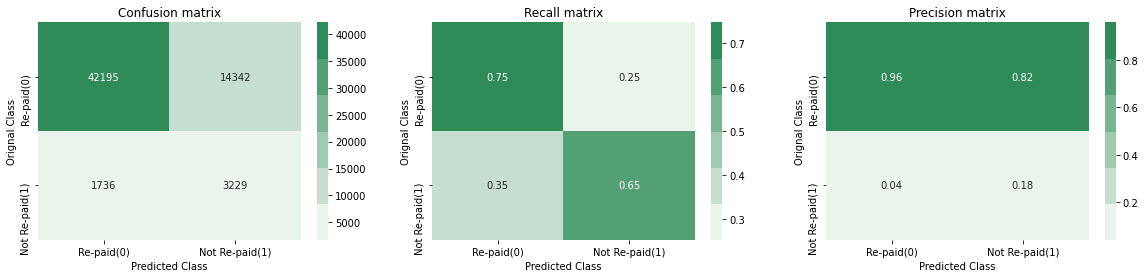

In [23]:
Stack_classifer_result  = meta_model(base_learner_df = base_learner_df, x_tr=X_train,y_tr=y_train,x_te=X_test,y_te =y_test, 
                                     actual_test_data = Actual_test, actual_test= False)

In [24]:
Stack_classifer_result  = meta_model(base_learner_df = base_learner_df, x_tr=X_train,y_tr=y_train,x_te=X_test,y_te =y_test, 
                                     actual_test_data = Actual_test, actual_test= True)

Custom_stacking started
XGboost started
XGBOOST Completed
RANDOM FOREST Started
RANDOM FOREST Completed
Light GBM Started
Light GBM Completed
Linear_SVM Started
Linear_SVM Completed
Linear_SVM_Log Started
Linear_SVM_Log Completed
ExtraTreesClassifier Started
ExtraTreesClassifier Completed
Custom_stacking Done
Execution completed


In [1]:
######################################################################################################

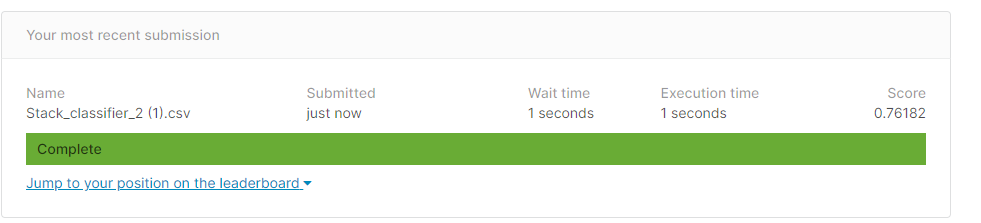